
**Predicting future values for time serieses using Machine Learning
Steps :**

(STEP1) Loading and preparing the time series

(STEP2) Visualize the series



*   Seasonality
*   Trend
*   Stationary 


(STEP3) xGBoost Model

## (STEP1) Loading and preparing the time series

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/CATFISH.csv')
df.head()

,Date,Total
0,1/1/1986,9034
1,2/1/1986,9596
2,3/1/1986,10558
3,4/1/1986,9002
4,5/1/1986,9239


In [ ]:
print(df.info())
print(df.describe())
print("\nnull values:\n",df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    324 non-null    object
 1   Total   324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB
None
              Total
count    324.000000
mean   19643.984568
std     5039.324331
min     8196.000000
25%    15764.000000
50%    19660.500000
75%    23604.500000
max    30485.000000

null values:
 Date     0
Total    0
dtype: int64


In [ ]:
df['Date'] = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    324 non-null    datetime64[ns]
 1   Total   324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


# (STEP2) Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df.head()

,Date,Total
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


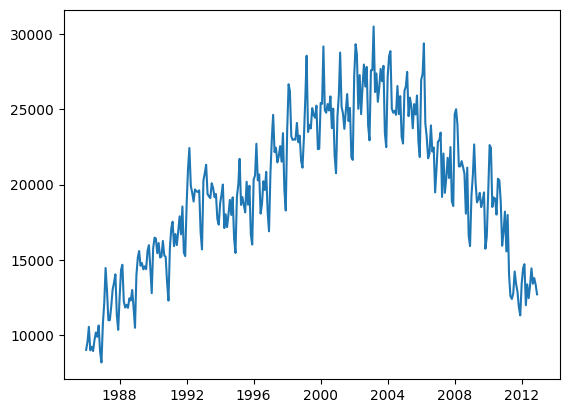

In [ ]:
# observing the correlation between Date and Total
plt.plot(df.Date,df.Total)
plt.show()

## Data Decomposition
Decomposition is a statistical job that involves breaking down Time Series data into many components or identifying seasonality and trend from a series of data

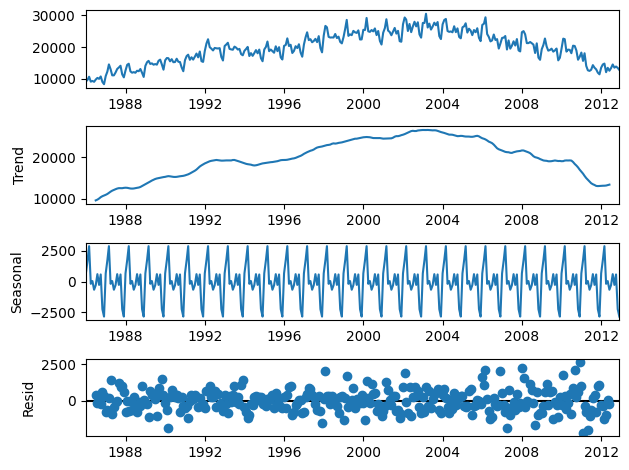

In [ ]:
# observing the data Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.set_index('Date', inplace = False), model = 'additive')
decomposition.plot()
plt.show()

# (STEP3) xGBoost Model

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

df.head()

,Date,Total
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


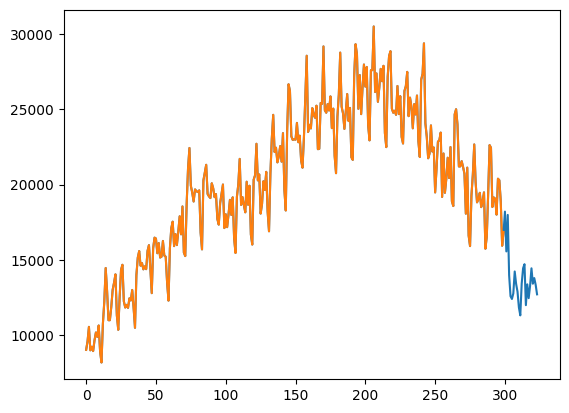

In [ ]:
# remove the tail that might cause errors 
# you might not need that step very much
plt.plot(df['Total'])
plt.plot(df['Total'][:-24])
df = df[:-24]

In [ ]:
# Create multible features (lagged variables)
lags = 10
for i in range(1, lags + 1):
    df[f'lag_{i}'] = df['Total'].shift(i)

df.head(lags+1)

,Date,Total,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
0,1986-01-01,9034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-02-01,9596,9034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986-03-01,10558,9596.0,9034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986-04-01,9002,10558.0,9596.0,9034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986-05-01,9239,9002.0,10558.0,9596.0,9034.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1986-06-01,8951,9239.0,9002.0,10558.0,9596.0,9034.0,NaN,NaN,NaN,NaN,NaN
6,1986-07-01,9668,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0,NaN,NaN,NaN,NaN
7,1986-08-01,10188,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0,NaN,NaN,NaN
8,1986-09-01,9896,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0,NaN,NaN
9,1986-10-01,10649,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0,NaN


In [ ]:
# Prepare the data for XGBoost

# split the data into (train, validate, test)

X_train = df[:220].drop(['Total', 'Date'], axis=1)
y_train = df[:220]['Total']

X_val = df[220:260].drop(['Total', 'Date'], axis=1)
y_val = df[220:260]['Total']

X_test = df[240:].drop(['Total', 'Date'], axis=1)
y_test = df[240:]['Total']


# put the data into a form of a matrix that fits into xGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Define the XGBoost model
params = {
    'max_depth': 5,
    'eta': 0.1,
    'gamma': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 100

# Train the XGBoost model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')]
)

[0]	validation-rmse:21604.21207
[1]	validation-rmse:19373.11734
[2]	validation-rmse:17465.10014
[3]	validation-rmse:15722.78020
[4]	validation-rmse:14151.51691
[5]	validation-rmse:12726.83447
[6]	validation-rmse:11391.07409
[7]	validation-rmse:10255.70804
[8]	validation-rmse:9179.13986
[9]	validation-rmse:8211.54758
[10]	validation-rmse:7362.04274
[11]	validation-rmse:6639.92050
[12]	validation-rmse:6048.71047
[13]	validation-rmse:5494.34611
[14]	validation-rmse:4958.41648
[15]	validation-rmse:4459.37820
[16]	validation-rmse:4046.58444
[17]	validation-rmse:3663.78303
[18]	validation-rmse:3318.69190
[19]	validation-rmse:3045.74361
[20]	validation-rmse:2836.25879
[21]	validation-rmse:2621.20189
[22]	validation-rmse:2462.90570
[23]	validation-rmse:2317.27934
[24]	validation-rmse:2182.01694
[25]	validation-rmse:2085.27874
[26]	validation-rmse:1996.68098
[27]	validation-rmse:1963.65391
[28]	validation-rmse:1949.94827
[29]	validation-rmse:1917.46297
[30]	validation-rmse:1873.19338
[31]	valid

In [ ]:
# Evaluate the XGBoost model on the test set
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"The test RMSE: {rmse}")

The test RMSE: 2217.659189866094


[]

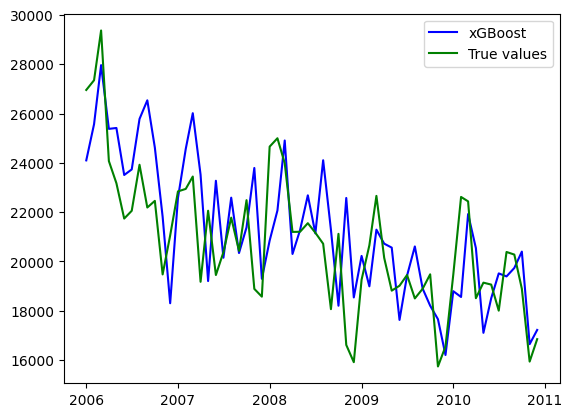

In [ ]:
plt.plot(df[240:].Date,y_pred, color = 'blue', label = 'xGBoost')
plt.plot(df[240:].Date,y_test.values, color = 'green', label = 'True values')
plt.legend()
plt.plot()